In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.feature_selection import SequentialFeatureSelector
from alpha_common_functions import lineplot

set_config(display="diagram")

In [2]:
df = pd.read_csv("data/vehicles_v3.csv")

# Drop Columns
#### 1. title_status has least variance with almost 95% of them have 'clean' status. We will not be considering the feature in model fitting.
#### 2. 71% of records are missing size, we will thus be skipping them too.
#### 3. region has 404 distinct values, this we will only consider state for the prediction 

In [3]:
df.drop(columns=['title_status','size','region'], inplace=True)

# Train - Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['price'], axis=1), df['price'], test_size = 0.3, random_state = 42)

# Answer check
print(X_train.shape)
print(X_test.shape)

(211026, 11)
(90440, 11)


# Pre Processing

![](images/PreProcessing.svg)

## Transformers

### cylinders - OrdinalEncoder
1. Similarly 15.61% od NaN will be lables as "other" and will combine with	0.24% of "other"
2. We will have total 7 unique categories
   Categories: [0.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0]
   unknown_category = 9
   missing_category = -1

In [5]:
categories_ = [[4.0, 6.0, 8.0]]
unknown_categories_ = len(categories_[0])
missing_categories_ = -1

cylinders_ordinal_encoder = OrdinalEncoder(encoded_missing_value=missing_categories_, categories=categories_, unknown_value=unknown_categories_, handle_unknown='use_encoded_value')                                           

### condition - OrdinalEncoder
1. 35.44% of records have no condition provided. we will be putting all of them to new label "other"
2. We will have total 7 unique categories
   Categories: ["salvage", "fair", "good", "excellent","like new", "new"]
   unknown_category = 6
   missing_category = -1


In [6]:
categories_=[["good", "excellent","like new", "new"]]
unknown_categories_ = len(categories_[0])
missing_categories_ = -1

condition_ordinal_encoder = OrdinalEncoder(encoded_missing_value=missing_categories_, categories=categories_, unknown_value=unknown_categories_, handle_unknown='use_encoded_value')                                           

### transmission - (SimpleImputer -> OneHotEncoder)
1. Only 0.33% of all records are null. We do have additional category of "other" which is 18%+. Thus we will add 0.33%  of null as "other"
2. This will narrow down the transmossion to just 3 subcategories
### fuel - (SimpleImputer -> OneHotEncoder)
1. 0.07% of nissing values will be combined with 7.88% of "others"
2. We will have total 5 unique categories
### type - (SimpleImputer -> OneHotEncoder)
1. 15.21 of NaN will be combined with 5.37% of Other
2. In Total 12 categories will be remaining
### drive - (SimpleImputer -> OneHotEncoder)
1. 26.31% of NaN will be renamed as "Others
2. Total remaining categories will be 4
### paint_color - (SimpleImputer -> OneHotEncoder)
1. 28.19% of NaN will be renamed as "Others
2. Total remaining categories will be 13

In [7]:
simple_imputer = SimpleImputer(strategy='constant', fill_value='other')

<div class="alert alert-block alert-success">
    <font size=6 color='black'>
        Model 4
    </font>
    <br>
    <font size=5 color='black'>
    <u>SequentialFeatureSelector</u>
    </font>
    <br>
    <font size=4 color='black'>
        1. ColumnTransformation<br>
        - OrdinalEncoder > PolynomialFeature (degree=2) on 'cylinders' and 'condition' on separate pipelines<br> 
        - SimpleImputer > OneHotEncoder on 'transmission','fuel', 'type', 'drive', 'paint_color' in a pipeline<br>
        - StandardScaler > PolynomialFeatures (degree=2) on ['year', 'odometer']<br>           
        2. SequentialFeatureSelector (n_features_to_select=15)<br>
        3. LinearRegression<br>    
    </font>
    </p>
</div>

In [8]:
transformer = make_column_transformer(
    (Pipeline([
        ('simple_imputer', simple_imputer),
        ('one_hot_encoder', OneHotEncoder())
    ]),['transmission','fuel', 'type', 'drive', 'paint_color']),
    (OneHotEncoder(),['manufacturer','state']),
    (Pipeline([
        ('ordinal',cylinders_ordinal_encoder), 
        ('poly', PolynomialFeatures(include_bias = False, degree = 2))]), ['cylinders']),     
    (Pipeline([
        ('ordinal',condition_ordinal_encoder), 
        ('poly', PolynomialFeatures(include_bias = False, degree = 2))]), ['condition']),     
    (Pipeline([
        ('scalar', StandardScaler()),
        ('poly', PolynomialFeatures(include_bias = False, degree = 2))
    ]) , ['year', 'odometer']),
    remainder='passthrough')

In [9]:
pipeline = Pipeline([
    ('transformer', transformer), 
    ('feature_selector', SequentialFeatureSelector(        
        LinearRegression(),
        scoring = 'neg_mean_squared_error',
        n_features_to_select=15,
        cv = 3,
        direction='forward'
    )),
    ('classifier', LinearRegression())
])

In [10]:
pipeline.fit(X_train[['transmission','fuel', 'type', 'drive', 'paint_color','condition','cylinders','manufacturer','state','year', 'odometer' ]], y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='other',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['transmission', 'fuel',
                                                   'type', 'drive',
                                                   'paint_color']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['manufacturer', 'state']),
                                                 ('pipelin...
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['condition']),
                                                 ('pipeline-4',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['year', 'odometer'])])),
                ('feature_selector',
                 SequentialFeatureSelector(cv=3, estimator=LinearRegression(),
                                           n_features_to_select=15,
                                           scoring='neg_mean_squared_error')),
                ('classifier', LinearRegression())])

In [11]:
y_train_predict = pipeline.predict(X_train[['transmission','fuel', 'type', 'drive', 'paint_color','condition','cylinders','manufacturer','state','year', 'odometer' ]])
y_test_predict = pipeline.predict(X_test[['transmission','fuel', 'type', 'drive', 'paint_color','condition','cylinders','manufacturer','state','year', 'odometer' ]])
#predict on train and test
train_mses=(mean_squared_error(y_train, y_train_predict))
test_mses=(mean_squared_error(y_test, y_test_predict))

In [12]:
print(train_mses)
print(test_mses)

40621101.505078465
40581119.91222496


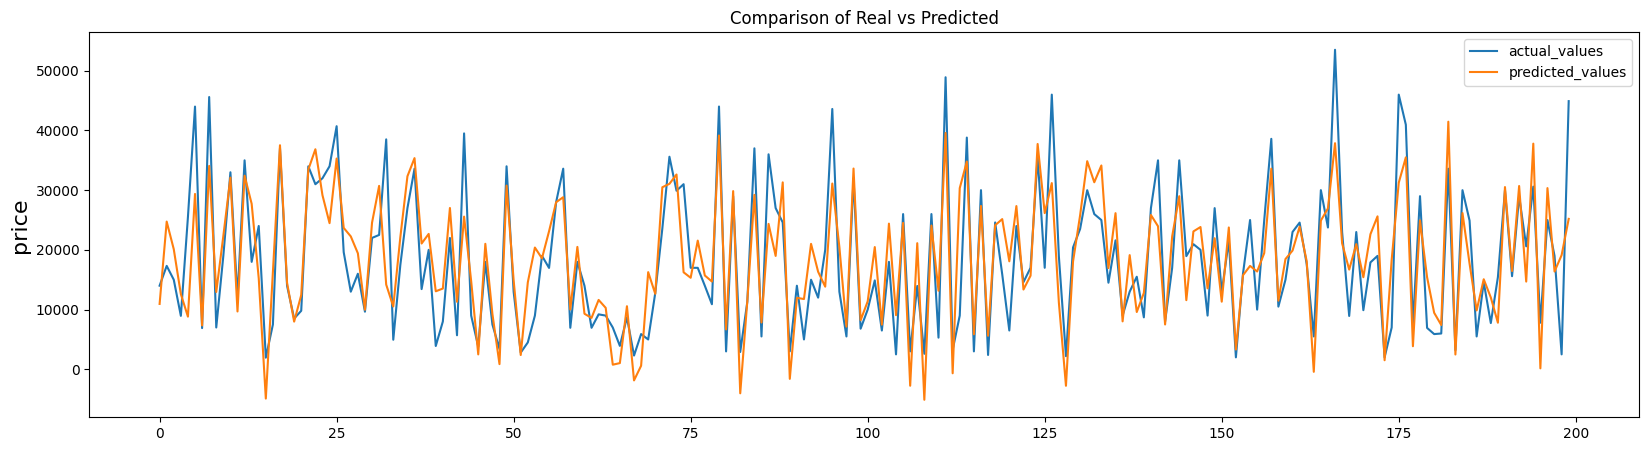

In [13]:
lineplot(y_test, y_test_predict, 200, "SequentialFeatureSearch_15Fields")

In [14]:
all_feature_names = pipeline.named_steps['transformer'].get_feature_names_out()

In [15]:
selected_features_mask = pipeline.named_steps['feature_selector'].get_support()
selected_feature_names = [name for name, selected in zip(all_feature_names, selected_features_mask) if selected]

selected_feature_names

['pipeline-1__fuel_diesel',
 'pipeline-1__type_pickup',
 'pipeline-1__type_truck',
 'pipeline-1__drive_fwd',
 'pipeline-1__drive_other',
 'onehotencoder__manufacturer_Audi',
 'onehotencoder__manufacturer_Nissan',
 'onehotencoder__manufacturer_Porsche',
 'onehotencoder__manufacturer_Toyota',
 'pipeline-2__cylinders',
 'pipeline-2__cylinders^2',
 'pipeline-4__year',
 'pipeline-4__odometer',
 'pipeline-4__year^2',
 'pipeline-4__odometer^2']

<div class="alert alert-block alert-warning">
    <font size=5, color='black'>
        Model 4
    </font>
    <br>
    <font size=4 color='black'>
    <u> Feature count: 15 </u><br>
    </font>
    <font size=3 color='black'>
    * Selecting just 15 fields to model made the MSE worse Then PolynomialFeature which models based on all all fields<br>
    </font>
</div>

<div class="alert alert-block alert-success">
    <font size=6 color='black'>
        Model 5
    </font>
    <br>
    <font size=5 color='black'>
    <u>SequentialFeatureSelector</u>
    </font>
    <br>
    <font size=4 color='black'>
        1. ColumnTransformation<br>
        - OrdinalEncoder > PolynomialFeature (degree=2) on 'cylinders' and 'condition' on separate pipelines<br> 
        - SimpleImputer > OneHotEncoder on 'transmission','fuel', 'type', 'drive', 'paint_color' in a pipeline<br>
        - StandardScaler > PolynomialFeatures (degree=2) on ['year', 'odometer']<br>           
        2. SequentialFeatureSelector (n_features_to_select=20)<br>
        3. LinearRegression<br>    
    </font>
    </p>
</div>

In [16]:
categories_ = [[0.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0]]
unknown_categories_ = len(categories_[0])
missing_categories_ = -1

cylinders_ordinal_encoder = OrdinalEncoder(encoded_missing_value=missing_categories_, categories=categories_, unknown_value=unknown_categories_, handle_unknown='use_encoded_value')                                           

In [17]:
categories_=[["salvage", "fair", "good", "excellent","like new", "new"]]
unknown_categories_ = len(categories_[0])
missing_categories_ = -1

condition_ordinal_encoder = OrdinalEncoder(encoded_missing_value=missing_categories_, categories=categories_, unknown_value=unknown_categories_, handle_unknown='use_encoded_value')                                           

In [18]:
transformer = make_column_transformer(
    (Pipeline([
        ('simple_imputer', simple_imputer),
        ('one_hot_encoder', OneHotEncoder())
    ]),['transmission','fuel', 'type', 'drive', 'paint_color']),
    (OneHotEncoder(),['manufacturer','state']),
    (Pipeline([
        ('ordinal',cylinders_ordinal_encoder), 
        ('poly', PolynomialFeatures(include_bias = False, degree = 2))]), ['cylinders']),     
    (Pipeline([
        ('ordinal',condition_ordinal_encoder), 
        ('poly', PolynomialFeatures(include_bias = False, degree = 2))]), ['condition']),     
    (Pipeline([
        ('scalar', StandardScaler()),
        ('poly', PolynomialFeatures(include_bias = False, degree = 2))
    ]) , ['year', 'odometer']),
    remainder='passthrough')

In [19]:
pipeline = Pipeline([
    ('transformer', transformer), 
    ('feature_selector', SequentialFeatureSelector(        
        LinearRegression(),
        scoring = 'neg_mean_squared_error',
        n_features_to_select=20,
        cv = 3,
        direction='forward'
    )),
    ('classifier', LinearRegression())
])

In [20]:
pipeline.fit(X_train[['transmission','fuel', 'type', 'drive', 'paint_color','condition','cylinders','manufacturer','state','year', 'odometer' ]], y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='other',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['transmission', 'fuel',
                                                   'type', 'drive',
                                                   'paint_color']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['manufacturer', 'state']),
                                                 ('pipelin...
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['condition']),
                                                 ('pipeline-4',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['year', 'odometer'])])),
                ('feature_selector',
                 SequentialFeatureSelector(cv=3, estimator=LinearRegression(),
                                           n_features_to_select=20,
                                           scoring='neg_mean_squared_error')),
                ('classifier', LinearRegression())])

In [21]:
y_train_predict = pipeline.predict(X_train[['transmission','fuel', 'type', 'drive', 'paint_color','condition','cylinders','manufacturer','state','year', 'odometer' ]])
y_test_predict = pipeline.predict(X_test[['transmission','fuel', 'type', 'drive', 'paint_color','condition','cylinders','manufacturer','state','year', 'odometer' ]])
#predict on train and test
train_mses=(mean_squared_error(y_train, y_train_predict))
test_mses=(mean_squared_error(y_test, y_test_predict))

In [22]:
print(train_mses)
print(test_mses)

39202495.23184522
39090014.52399856


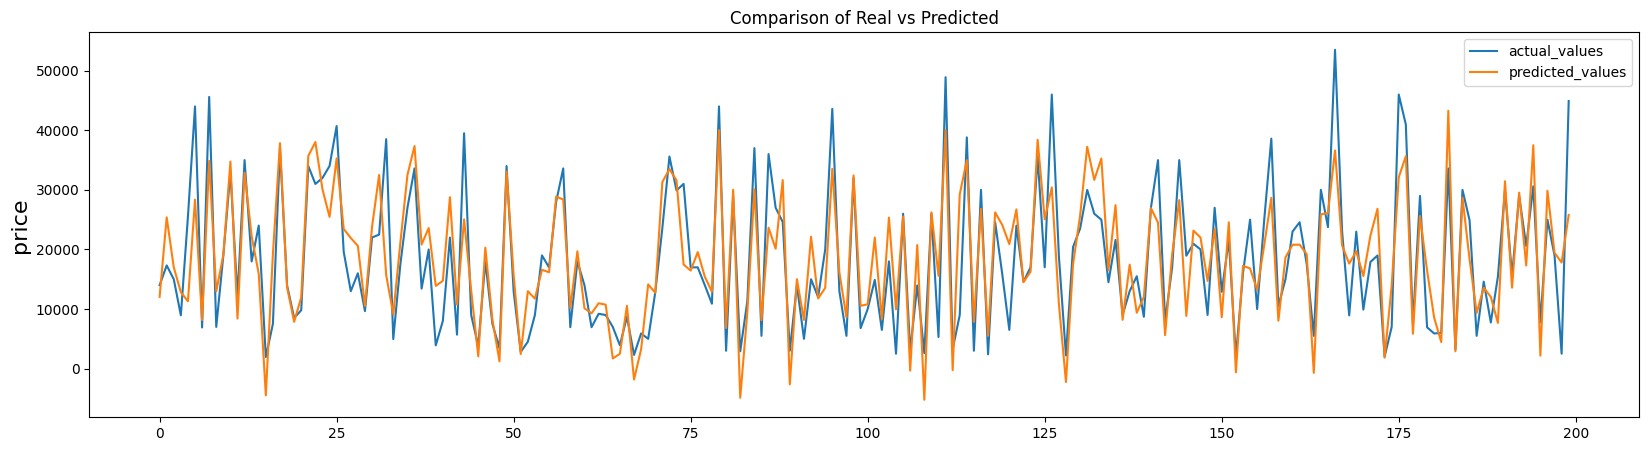

In [23]:
lineplot(y_test, y_test_predict, 200, "SequentialFeatureSearch_20Fields")

In [24]:
all_feature_names = pipeline.named_steps['transformer'].get_feature_names_out()

In [25]:
selected_features_mask = pipeline.named_steps['feature_selector'].get_support()
selected_feature_names = [name for name, selected in zip(all_feature_names, selected_features_mask) if selected]

selected_feature_names

['pipeline-1__transmission_automatic',
 'pipeline-1__fuel_diesel',
 'pipeline-1__fuel_gas',
 'pipeline-1__type_pickup',
 'pipeline-1__type_truck',
 'pipeline-1__drive_fwd',
 'pipeline-1__drive_other',
 'onehotencoder__manufacturer_Dodge',
 'onehotencoder__manufacturer_Hyundai',
 'onehotencoder__manufacturer_Kia',
 'onehotencoder__manufacturer_Mitsubishi',
 'onehotencoder__manufacturer_Nissan',
 'onehotencoder__manufacturer_Porsche',
 'pipeline-2__cylinders',
 'pipeline-2__cylinders^2',
 'pipeline-3__condition^2',
 'pipeline-4__year',
 'pipeline-4__odometer',
 'pipeline-4__year^2',
 'pipeline-4__odometer^2']

<div class="alert alert-block alert-warning">
    <font size=5, color='black'>
        Model 5
    </font>
    <br>
    <font size=4 color='black'>
    <u> Feature count: 20 </u><br>
    </font>
    <font size=3 color='black'>
    * Selecting just 20 fields instead of 15 had good improvement but it was still a tiny portion worse than PolynomialFeature<br>
    </font>
</div>

<div class="alert alert-block alert-success">
    <font size=6 color='black'>
        Model 6
    </font>
    <br>
    <font size=5 color='black'>
    <u>SequentialFeatureSelector</u>
    </font>
    <br>
    <font size=4 color='black'>
        1. ColumnTransformation<br>
        - OrdinalEncoder > PolynomialFeature (degree=2) on 'cylinders' and 'condition' on separate pipelines<br> 
        - SimpleImputer > OneHotEncoder on 'transmission','fuel', 'type', 'drive', 'paint_color' in a pipeline<br>
        - StandardScaler > PolynomialFeatures (degree=2) on ['year', 'odometer']<br>           
        2. SequentialFeatureSelector (n_features_to_select=30)<br>
        3. LinearRegression<br>    
    </font>
    </p>
</div>

In [26]:
pipeline = Pipeline([
    ('transformer', transformer), 
    ('feature_selector', SequentialFeatureSelector(        
        LinearRegression(),
        scoring = 'neg_mean_squared_error',
        n_features_to_select=30,
        cv = 3,
        direction='forward'
    )),
    ('classifier', LinearRegression())
])

In [27]:
pipeline.fit(X_train[['transmission','fuel', 'type', 'drive', 'paint_color','condition','cylinders','manufacturer','state','year', 'odometer' ]], y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='other',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['transmission', 'fuel',
                                                   'type', 'drive',
                                                   'paint_color']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['manufacturer', 'state']),
                                                 ('pipelin...
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['condition']),
                                                 ('pipeline-4',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['year', 'odometer'])])),
                ('feature_selector',
                 SequentialFeatureSelector(cv=3, estimator=LinearRegression(),
                                           n_features_to_select=30,
                                           scoring='neg_mean_squared_error')),
                ('classifier', LinearRegression())])

In [28]:
y_train_predict = pipeline.predict(X_train[['transmission','fuel', 'type', 'drive', 'paint_color','condition','cylinders','manufacturer','state','year', 'odometer' ]])
y_test_predict = pipeline.predict(X_test[['transmission','fuel', 'type', 'drive', 'paint_color','condition','cylinders','manufacturer','state','year', 'odometer' ]])
#predict on train and test
train_mses=(mean_squared_error(y_train, y_train_predict))
test_mses=(mean_squared_error(y_test, y_test_predict))

In [29]:
print(train_mses)
print(test_mses)

37303420.38294286
37126532.58778653


In [30]:
all_feature_names = pipeline.named_steps['transformer'].get_feature_names_out()

In [31]:
selected_features_mask = pipeline.named_steps['feature_selector'].get_support()
selected_feature_names = [name for name, selected in zip(all_feature_names, selected_features_mask) if selected]

selected_feature_names

['pipeline-1__transmission_automatic',
 'pipeline-1__fuel_diesel',
 'pipeline-1__fuel_gas',
 'pipeline-1__type_hatchback',
 'pipeline-1__type_pickup',
 'pipeline-1__type_sedan',
 'pipeline-1__type_truck',
 'pipeline-1__drive_fwd',
 'pipeline-1__drive_other',
 'onehotencoder__manufacturer_Audi',
 'onehotencoder__manufacturer_Chrysler',
 'onehotencoder__manufacturer_Dodge',
 'onehotencoder__manufacturer_Hyundai',
 'onehotencoder__manufacturer_Kia',
 'onehotencoder__manufacturer_Lexus',
 'onehotencoder__manufacturer_Mercedes-Benz',
 'onehotencoder__manufacturer_Mitsubishi',
 'onehotencoder__manufacturer_Nissan',
 'onehotencoder__manufacturer_Porsche',
 'onehotencoder__manufacturer_Rover',
 'onehotencoder__manufacturer_Tesla',
 'onehotencoder__manufacturer_Toyota',
 'onehotencoder__manufacturer_Volkswagen',
 'pipeline-2__cylinders',
 'pipeline-2__cylinders^2',
 'pipeline-3__condition^2',
 'pipeline-4__year',
 'pipeline-4__odometer',
 'pipeline-4__year^2',
 'pipeline-4__odometer^2']

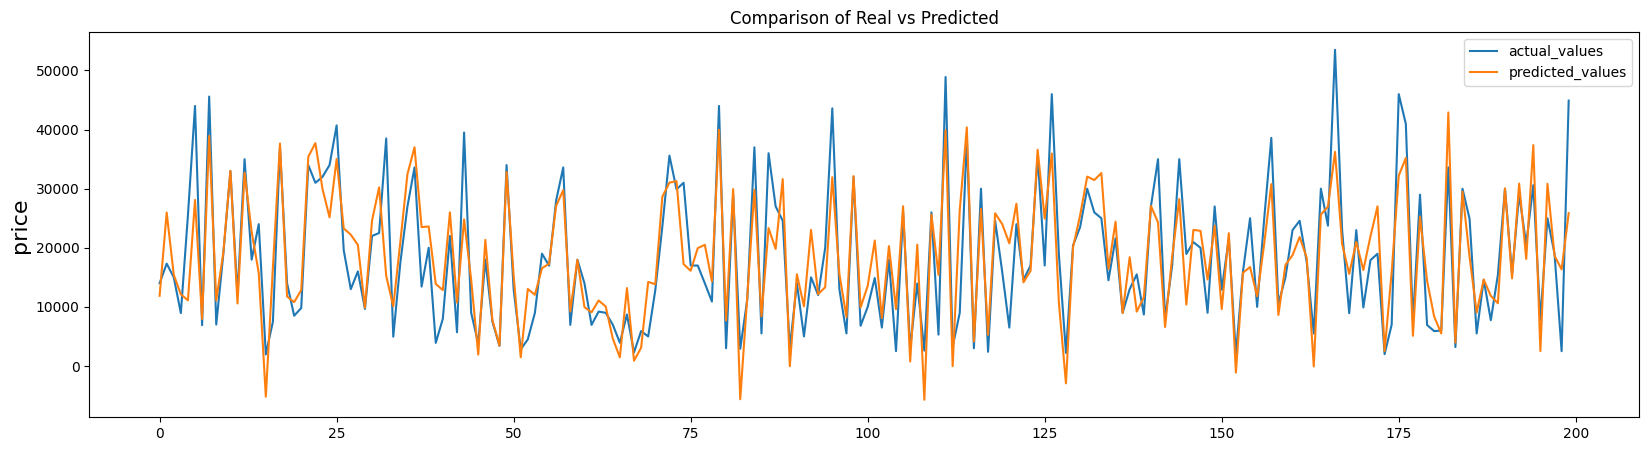

In [32]:
lineplot(y_test, y_test_predict, 200, "SequentialFeatureSearch_30Fields")

<div class="alert alert-block alert-warning">
    <font size=5, color='black'>
        Model 6
    </font>
    <br>
    <font size=4 color='black'>
    <u> Feature count: 30 </u><br>
    </font>
    <font size=3 color='black'>
    * Selecting just 30 fields to model better model in both 15 or 20 fields Selection. Its Still better than PolynomialFeature on Just 2 fields (fuel, odometer) but tiny portion worse than PolynomialFeature on all fields<br>
    </font>
</div>